# M1. Actividad
### Daniel Sebastián Cajas Morales
### A01708637

Para este problema, deberás entregar, de manera individual, un informe en PDF que estudie las estadísticas de un robot de limpieza reactivo, así como el enlace al repositorio en Github del código desarrollado para esta actividad. El código debe ajustarse al estilo solicita en el siguiente documento.

#### Dado:
- Habitación de MxN espacios.
- Número de agentes.
- Porcentaje de celdas inicialmente sucias.
- Tiempo máximo de ejecución.

#### Realiza la siguiente simulación:
- Inicializa las celdas sucias (ubicaciones aleatorias).
- Todos los agentes empiezan en la celda [1,1].
- En cada paso de tiempo:
    - Si la celda está sucia, entonces aspira.
    - Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda).
- Se ejecuta el tiempo máximo establecido.

In [56]:
from mesa import Agent, Model 
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run
# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

import numpy as np
import pandas as pd

import time

from IPython import display 

In [57]:
class CleaningAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

    def step(self):
        isDirty = self.model.floorGrid[self.pos[0]][self.pos[1]]
        if isDirty:
            self.model.floorGrid[self.pos[0]][self.pos[1]] = False
        else:
            self.move()

    def move(self):
        neighbourCells = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False)
        emptyNeighbours = [c for c in neighbourCells if self.model.grid.is_cell_empty(c)]
        if len(emptyNeighbours) > 0:
            new_position = self.random.choice(emptyNeighbours)
            self.model.grid.move_agent(self, new_position)
        

In [58]:
class CleaningModel(Model):
    def __init__(self, num_agents, width, height, initial_dirty_cells, collector):
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, False)

        
        self.floorGrid = np.random.random(
            (width, height)) <= initial_dirty_cells
        

        self.datacollector = collector
        self.running = True
        self.shouldStop = False
        self.timeStart = time.time()
        self.timeTaken = 0

        for i in range(num_agents):
            agent = CleaningAgent(i, self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (1, 1))

    def step(self):
        self.datacollector.collect(self)

        self.schedule.step()

        self.timeTaken = time.time() - self.timeStart

        if (self.shouldStop):
            self.running = False
            
        if (self.floorGrid.sum() == 0):
            self.shouldStop = True

    def getFloor(self):
        return self.floorGrid.copy()

    def getCleaners(self):
        cleanerGrid = np.full((self.grid.width, self.grid.height), False)

        for cell in self.grid.coord_iter():
            cell_content, (x, y) = cell
            if len(cell_content) > 0:
                cleanerGrid[x][y] = True

        return cleanerGrid

    def getCleanPercentage(self):
        cleanFraction = 1 - self.floorGrid.sum() / self.floorGrid.size
        return cleanFraction * 100

In [59]:
def runSim(num_agents, grid_with, grid_height, steps, initial_dirty_cells, display=False):

    reporters = {"timeTaken": "timeTaken",
                 "CleanPercentage": CleaningModel.getCleanPercentage}
    if display:
        reporters["Floor"] = CleaningModel.getFloor
        reporters["Cleaners"] = CleaningModel.getCleaners

    model = CleaningModel(num_agents, grid_with, grid_height, initial_dirty_cells, DataCollector(
        model_reporters=reporters))
    iPerPercent = steps // 100
    for i in range(steps):
        if i % iPerPercent == 0:
            print("Progress: " + str(i // iPerPercent) + "%", end="\r")

        model.step()
        if not model.running:
            break

    print("Progress: 100%", end="\r")

    render1 = None
    all_grid = model.datacollector.get_model_vars_dataframe()
    if display:

        # animar el piso
        fig, axs = plt.subplots(figsize=(7, 7))
        axs.set_xticks([])
        axs.set_yticks([])

        total_steps = len(all_grid)
        step = max(total_steps // 500, 1)
        floors = all_grid.get("Floor")
        floors = floors.iloc[::step].reset_index(drop=True)
        cleaners = all_grid.get("Cleaners")
        cleaners = cleaners.iloc[::step].reset_index(drop=True)
        frames = floors + 2 * cleaners
        patch = plt.imshow(frames[0], cmap=plt.cm.binary)
        plt.clim(0, 3)
        plt.close()
        anim = animation.FuncAnimation(
            fig, lambda i: patch.set_data(frames[i]), frames=len(frames))
        render1 = anim.to_jshtml()

    return render1, all_grid

In [60]:
GRID_WIDTH = 100
GRID_HEIGHT = 100

## Animaciones
5 agentes, 90% de celdas sucias.


In [79]:
AGENTS = 5
DIRTY_CELLS = 0.9

In [80]:
# (r1, data) = runSim(1, GRID_WIDTH, GRID_HEIGHT, 100000, DIRTY_CELLS)
r1, data1 = runSim(AGENTS, 10, 10, 10000, DIRTY_CELLS, True)

### Animación
- Blanco = Limpio
- Gris claro = Sucio
- Gris obscuro = Aspiradora en piso limpio
- Negro = Aspiradora en piso sucio

In [81]:
display.HTML(r1)

## Escenario 1
1 agente, 90% de celdas sucias.


In [64]:
AGENTS = 1
DIRTY_CELLS = 0.9

In [65]:
_, data1 = runSim(AGENTS, GRID_WIDTH, GRID_HEIGHT, 10000000, DIRTY_CELLS)

### Deberás resolver las siguientes preguntas:

¿Cuántos pasos de simulación toma limpiar todo el espacio?

In [66]:
print("Tomaron " + str(len(data1)) + " pasos para limpiar el espacio")

Tomaron 282219 pasos para limpiar el espacio


¿Qué porcentaje de celdas sucias queda con los siguientes pasos de simulación: 100, 1000, 10000?

In [67]:
_, data1_1 = runSim(AGENTS, GRID_WIDTH, GRID_HEIGHT, 100, DIRTY_CELLS)
_, data1_2 = runSim(AGENTS, GRID_WIDTH, GRID_HEIGHT, 1000, DIRTY_CELLS)
_, data1_3 = runSim(AGENTS, GRID_WIDTH, GRID_HEIGHT, 10000, DIRTY_CELLS)
print(f"En 100 pasos se limpió el {data1_1.get('CleanPercentage').iloc[-1]:.2f} % del espacio")
print(f"En 1000 pasos se limpió el {data1_2.get('CleanPercentage').iloc[-1]:.2f} % del espacio")
print(f"En 10000 pasos se limpió el {data1_3.get('CleanPercentage').iloc[-1]:.2f} % del espacio")

En 100 pasos se limpió el 10.47 % del espacio
En 1000 pasos se limpió el 13.25 % del espacio
En 10000 pasos se limpió el 28.09 % del espacio


## Escenario 2
2 agente, 90% de celdas sucias.


In [68]:
AGENTS = 2
DIRTY_CELLS = 0.9

In [69]:
_, data2 = runSim(AGENTS, GRID_WIDTH, GRID_HEIGHT, 1000000, DIRTY_CELLS)

### Deberás resolver las siguientes preguntas:

¿Cuántos pasos de simulación toma limpiar todo el espacio?

In [70]:
print("Tomaron " + str(len(data2)) + " pasos para limpiar el espacio")

Tomaron 125809 pasos para limpiar el espacio


¿Qué porcentaje de celdas sucias queda con los siguientes pasos de simulación: 100, 1000, 10000?

In [71]:
_, data2_1 = runSim(AGENTS, GRID_WIDTH, GRID_HEIGHT, 100, DIRTY_CELLS)
_, data2_2 = runSim(AGENTS, GRID_WIDTH, GRID_HEIGHT, 1000, DIRTY_CELLS)
_, data2_3 = runSim(AGENTS, GRID_WIDTH, GRID_HEIGHT, 10000, DIRTY_CELLS)
print(f"En 100 pasos se limpió el {data2_1.get('CleanPercentage').iloc[-1]:.2f} % del espacio")
print(f"En 1000 pasos se limpió el {data2_2.get('CleanPercentage').iloc[-1]:.2f} % del espacio")
print(f"En 10000 pasos se limpió el {data2_3.get('CleanPercentage').iloc[-1]:.2f} % del espacio")

En 100 pasos se limpió el 10.47 % del espacio
En 1000 pasos se limpió el 14.06 % del espacio
En 10000 pasos se limpió el 44.37 % del espacio


# Multiples modelos con diferentes valores

In [72]:
temp = batch_run(model_cls=CleaningModel, parameters={
    "num_agents": range(1, 21), "width": GRID_WIDTH, "height": GRID_HEIGHT, "initial_dirty_cells": DIRTY_CELLS, "collector": DataCollector(
        model_reporters={
            "timeTaken": "timeTaken",
            "CleanPercentage": CleaningModel.getCleanPercentage})
},
    iterations=100,
    number_processes=16,
    display_progress=True,
    max_steps=10000000
)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [73]:
data1 = pd.DataFrame(temp).drop(columns=["collector", "RunId", "iteration", "width", "height", "initial_dirty_cells"])

Se promedian los resultados para cada conteo de agentes

In [77]:
grouped = data1.groupby(["num_agents"]).mean()

### Pasos para limpiar
Podemos ver como a medida que aumentamos la cantidad de agentes, menos pasos toma. Esto tiene ventajas cada vez menores, cada vez que aumentan los agentes, se reducen los pasos pero menos y menos. por ende habria que encontrar un balance entre el costo de un agente y la reducción en steps. Si tenemos un máximo de 10 agentes este sería la opción mas óptima

Viendo el plot tiene similaridades con un gráfico **y=1/(e^x)**

Text(0.5, 1.0, 'Steps taken against number of agents')

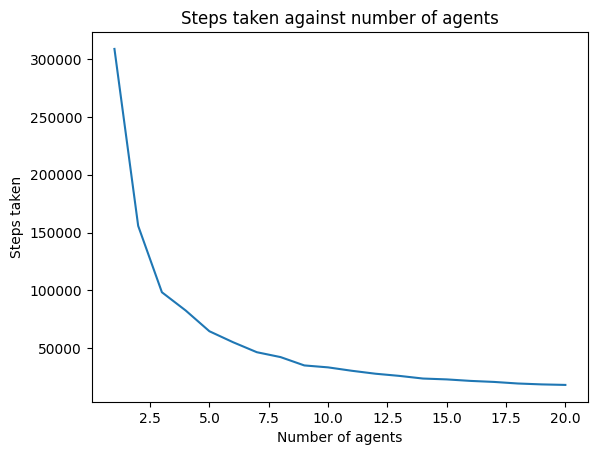

In [78]:
# plot steps against number of agents
plt.plot(grouped.index, grouped["Step"])
plt.xlabel("Number of agents")
plt.ylabel("Steps taken")
plt.title("Steps taken against number of agents")

### Tiempo de ejecución
Esto tiene un comportamiento muy similar al de pasos. Esto es porque si bien al agregar ams agentes, es mas coputacionalmetne costoso cada paso, se deben tomar menos pasos para completar la actividad. Por esto tenemos un costo incial alto y a medida que aumentamos parece volverse constante. Es probable que cuando se aumente aun mas los agentes, el tiempo de ejecución comience a crecer denuevo.



Text(0.5, 1.0, 'Time taken against number of agents')

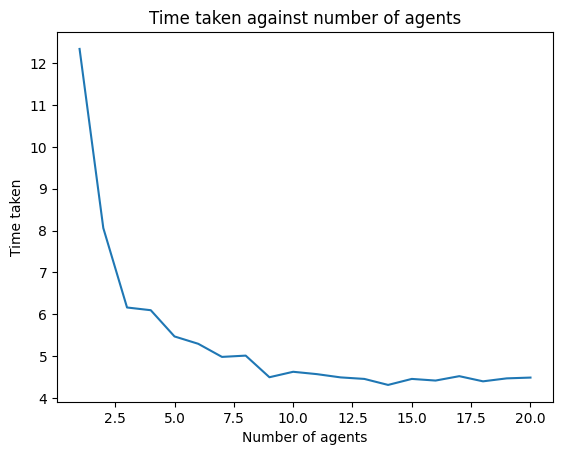

In [82]:
# plot time taken against number of agents
plt.plot(grouped.index, grouped["timeTaken"])
plt.xlabel("Number of agents")
plt.ylabel("Time taken")
plt.title("Time taken against number of agents")